In [1]:
# 调整页面宽度
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
from sklearn.linear_model import LinearRegression
from datetime import datetime
import time
from WindPy import w
w.start()

start='2010-01-01'
last='2021-12-11'

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


# 自定义函数

In [4]:
# 时间比较，返回较晚的日期
def compare_time(time1,time2):
    s_time = time.mktime(time.strptime(time1,'%Y-%m-%d'))
    e_time = time.mktime(time.strptime(time2,'%Y-%m-%d'))
    if s_time>e_time:
        time3=time1
    else:
        time3=time2
    return time3
# result = compare_time('2003-04-17','2010-04-19')
# print ('the compare result is:',result)

# 导入因子数据

In [3]:
 
#导入基准数据并变成收益率序列        

baselist0=["CBA00601.CS","CBA02521.CS","CBA02561.CS","CBA04201.CS","CBA02501.CS","CBA03801.CS","000832.CSI"]
baseimport=w.wsd(baselist0,"close", start, last, "Period=W")
baselist1=['zong','short','long','AAA','govern','highrate','stock']
# zong#中债总财富指数
# short=w.wsd("CBA00721.CS", "close", "start", "last", "") #中债国债中短期(1-3)总财富指数
# long=w.wsd("CBA00861.CS", "close", "start", "last", "")  #中债国债长期(7-10)债券指数
# AAA=w.wsd("CBA04201.CS", "close", "start", "last", "") #中债企业债 AAA 指数
# govern=w.wsd("CBA02501.CS", "close", "start", "last", "") #中债国开行债券指数
# highrate=w.wsd("CBA03801.CS", "close", "start", "last", "") #中债高收益企业债指数
# stock=w.wsd("000832.CSI", "close", "start", "last", "") #中证转债
dates=pd.to_datetime(baseimport.Times)
base = pd.DataFrame(baseimport.Data).T
print(base)
base.index = dates.strftime("%Y-%m-%d")
base.columns = baselist1
base=base.pct_change()*100
print(base)

#导入基准久期数据 
durationlist0=["CBA00601.CS","CBA02521.CS","CBA02561.CS","CBA04201.CS","CBA02501.CS","CBA03801.CS","000832.CSI"]
durationimport=w.wsd(baselist0,"duration", start, last, "Period=W")
durationlist1=['zong','short','long','AAA','govern','highrate','stock']
dates=pd.to_datetime(durationimport.Times)
duration = pd.DataFrame(durationimport.Data).T
duration.index = dates.strftime("%Y-%m-%d")
duration.columns = durationlist1


            0         1         2         3         4         5         6
0    128.5676  125.0125  138.7916  108.9665  132.8532  109.1628  331.7950
1    128.4350  125.0292  138.8167  109.1427  132.8754  109.4800  333.7700
2    128.7902  125.1332  139.2815  109.7801  133.0543  110.1745  324.7180
3    129.3397  125.2603  139.9107  110.0299  133.3421  110.3730  301.8200
4    130.0338  125.4093  140.3439  110.2891  133.6726  110.6626  297.5680
..        ...       ...       ...       ...       ...       ...       ...
607  204.2102  195.5202  272.6442  194.8446  212.8200  237.0391  421.7238
608  204.5027  195.7725  273.0009  195.0732  213.1096  237.5035  423.8014
609  205.3090  196.0512  273.9726  195.3585  213.6381  237.8693  426.7086
610  204.8871  196.0183  273.8502  195.5549  213.5547  238.2174  433.9643
611  205.3213  196.2169  275.0367  195.8229  213.9489  238.5794  431.1338

[612 rows x 7 columns]
                zong     short      long       AAA    govern  highrate  \
2010-01-08    

# 构造因子

In [4]:
# 构造因子
# level——zong
# slope——long and short
# credit——AAA and govern
# default——highrate and AAA
# convert——stock and zong

# 久期因子（level）——利率曲线变动的影响（beta影响）——中债国债总财富指数
level=base['zong']

# 利率曲线结构（slope）——中债中短期债券指数和中债长期债券指数——久期中性（权重动态调整）
slope=base['short']*duration['long']/duration['short']-base['long']

# 信用利差（credit）——中债企业债 AAA 指数和中债国开行债券指数——久期中性（权重动态调整）
credit=base['AAA']*duration['govern']/duration['AAA']-base['govern']

# 违约（default）——中债高收益企业债指数和中债企业债 AAA 指数——久期中性（权重动态调整）
default=base['highrate']*duration['AAA']/duration['highrate']-base['AAA']

# 可转债因子（convertible）——中证转债和中债国债总财富指数
convert=(base['stock']-base['zong'])

# 画图
# level.plot(kind='line',grid=True,label='level',title='level')
# slope.plot(kind='line',grid=True,label='slope',title='slope')
# credit.plot(kind='line',grid=True,label='credit',title='credit')
# default.plot(kind='line',grid=True,label='default',title='default')
# convert.plot(kind='line',grid=True,label='convert',title='factors')

# 导出因子序列
levelSeries=pd.Series(level,index=base.index)
slopeSeries=pd.Series(slope,index=base.index)
creditSeries=pd.Series(credit,index=base.index)
defaultSeries=pd.Series(default,index=base.index)
convertSeries=pd.Series(convert,index=base.index)

factor_nav=pd.concat([levelSeries,slopeSeries,creditSeries,defaultSeries,convertSeries],axis=1)
factor_nav.columns=['level','slope','credit','default','convert']
print(factor_nav)

               level     slope    credit   default   convert
2010-01-08       NaN       NaN       NaN       NaN       NaN
2010-01-15 -0.103136  0.036493  0.127038  0.167562  0.698383
2010-01-22  0.276560  0.004201  0.383628  0.131272 -2.988607
2010-01-29  0.426663 -0.035422 -0.013985 -0.023638 -7.478320
2010-02-05  0.536649  0.179923 -0.037991  0.063686 -1.945436
...              ...       ...       ...       ...       ...
2021-11-12 -0.114359  0.036734  0.079167  0.158017  2.782184
2021-11-19  0.143235  0.682678  0.062967  0.156586  0.349410
2021-11-26  0.394274  0.532509  0.002515  0.066800  0.291708
2021-12-03 -0.205495 -0.060510  0.210346  0.100335  1.905883
2021-12-10  0.211922  0.203769  0.048489  0.072655 -0.864164

[612 rows x 5 columns]


# 生成因子收益率序列

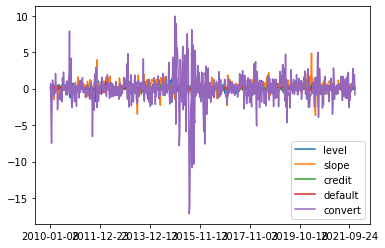

               level     slope    credit   default   convert
2010-01-08       NaN       NaN       NaN       NaN       NaN
2010-01-15 -0.103136  0.036493  0.127038  0.167562  0.698383
2010-01-22  0.276560  0.004201  0.383628  0.131272 -2.988607
2010-01-29  0.426663 -0.035422 -0.013985 -0.023638 -7.478320
2010-02-05  0.536649  0.179923 -0.037991  0.063686 -1.945436
...              ...       ...       ...       ...       ...
2021-11-12 -0.114359  0.036734  0.079167  0.158017  2.782184
2021-11-19  0.143235  0.682678  0.062967  0.156586  0.349410
2021-11-26  0.394274  0.532509  0.002515  0.066800  0.291708
2021-12-03 -0.205495 -0.060510  0.210346  0.100335  1.905883
2021-12-10  0.211922  0.203769  0.048489  0.072655 -0.864164

[612 rows x 5 columns]


In [5]:
factor=factor_nav
factor.columns=['level','slope','credit','default','convert']
factor.plot()
plt.legend()
plt.show()
writer = pd.ExcelWriter('华宝五因子.xlsx')
factor.to_excel(writer, 'page_1', float_format='%.3f')		# ‘page_1’是写入excel的sheet名
writer.save()
print(factor)

# 相关性分析

In [6]:
#相关性分析
# 疑问：为什么研报里相关性那么小？
# factor0=factor.pct_change().dropna() #收益率序列的相关性分析
cormatrix=factor.corr()
print('相关性分析')
print(cormatrix)

相关性分析
            level     slope    credit   default   convert
level    1.000000  0.186285 -0.192302 -0.231964 -0.123773
slope    0.186285  1.000000  0.094707 -0.005771  0.163361
credit  -0.192302  0.094707  1.000000 -0.167638  0.112616
default -0.231964 -0.005771 -0.167638  1.000000  0.089226
convert -0.123773  0.163361  0.112616  0.089226  1.000000


# 读取中长期纯债基金名单与截取因子日期

In [7]:
# # 读取基金名单——之后可以放程序
io = r'C:\Users\DELL\Desktop\债基整理\中长期纯债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist=originallist.sort_values(by='incdate').reset_index(drop=True)
originallist.to_excel('中长期纯债基金名单.xlsx', index=False)
fund_long=pd.read_excel('中长期纯债基金名单.xlsx')
fund_long=fund_long.sort_values(by='incdate').reset_index(drop=True)
fund_long['int_date']=fund_long['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_long=fund_long[(fund_long['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得中长债基金收益率数据

In [8]:
fund_long_data=w.wsd(fund_long['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_long_data.Times)
fund_long_data.index = date.strftime("%Y-%m-%d")
fund_long_rate= pd.DataFrame(fund_long_data.Data).T
fund_long_rate.index=fund_long_data.index
fund_long_rate.drop(fund_long_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_long)):
    jijin=w.wsd(fund_long['fcode'][i],"NAV_adj",compare_time(fund_long['incdate'][i].strftime("%Y-%m-%d"),start),last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_long_rate=pd.concat([fund_long_rate,jj],axis=1)
print(fund_long_rate)
writer_long = pd.ExcelWriter('中长期债基收益率.xlsx')
fund_long_rate.to_excel(writer_long, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_long.save()


100%|██████████████████████████████████████████████████████████████████████████████| 1542/1542 [11:15<00:00,  2.28it/s]


            217003.OF  161603.OF  371020.OF  519985.OF  100058.OF  040026.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.457457   0.176056   0.197628        NaN        NaN        NaN   
2010-01-22  -0.091075  -0.378072   0.098619        NaN        NaN        NaN   
2010-01-29  -0.783956  -0.853890   0.098522        NaN        NaN        NaN   
2010-02-05   0.238883  -0.191388   0.196850        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.023866   0.091996   2.401209   0.034798   0.017122   0.000000   
2021-11-19   0.182932   0.275735   0.597873   0.104357   0.119832   0.095329   
2021-11-26   0.214354   0.274977   0.995678   0.147685   0.162435   0.161905   
2021-12-03   0.023766   0.091408   1.536110   0.000000   0.025606   0.076067   
2021-12-10   0.102962   0.091324  -0.496764   0.104094   0.110931   0.114014   

            261002.OF  110037.OF  16101

# 读取短期纯债基金名单与截取因子日期

In [9]:
io = r'C:\Users\DELL\Desktop\债基整理\短期纯债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist=originallist.sort_values(by='incdate').reset_index(drop=True)
originallist.to_excel('短期纯债基金名单.xlsx', index=False)
fund_short=pd.read_excel('短期纯债基金名单.xlsx')
fund_short=fund_short.sort_values(by='incdate').reset_index(drop=True)
fund_short['int_date']=fund_short['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_short=fund_short[(fund_short['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得短债基金收益率数据

In [10]:
fund_short_data=w.wsd(fund_short['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_short_data.Times)
fund_short_data.index = date.strftime("%Y-%m-%d")
fund_short_rate= pd.DataFrame(fund_short_data.Data).T
fund_short_rate.index=fund_short_data.index
fund_short_rate.drop(fund_short_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_short)):
    jijin=w.wsd(fund_short['fcode'][i],"NAV_adj",compare_time(fund_short['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_short_rate=pd.concat([fund_short_rate,jj],axis=1)
print(fund_short_rate)
writer_short = pd.ExcelWriter('短期债基收益率.xlsx')
fund_short_rate.to_excel(writer_short, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_short.save()


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [01:16<00:00,  2.32it/s]


            270043.OF  040045.OF  000084.OF  000128.OF  000503.OF  000394.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-22        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-29        NaN        NaN        NaN        NaN        NaN        NaN   
2010-02-05        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2021-11-12        0.0   0.046045   0.061819   0.033190   0.043773   0.063997   
2021-11-19        0.0   0.082842   0.077226   0.049768   0.026891   0.054820   
2021-11-26        0.0   0.073577   0.054017   0.058033   0.071691   0.073053   
2021-12-03        0.0   0.055142   0.053987   0.033143   0.036204   0.045625   
2021-12-10        0.0   0.064297   0.054037   0.041415   0.065353   0.054725   

            002301.OF  002864.OF  51919

# 读取混合一级债基名单与截取因子日期

In [11]:
io =r'C:\Users\DELL\Desktop\债基整理\混合一级债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist=originallist.sort_values(by='incdate').reset_index(drop=True)
originallist.to_excel('混合一级债基金名单.xlsx', index=False)
fund_first=pd.read_excel('混合一级债基金名单.xlsx')
fund_first=fund_first.sort_values(by='incdate').reset_index(drop=True)
fund_first['int_date']=fund_first['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_first=fund_first[(fund_first['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得混合一级债基金收益率数据

In [12]:
fund_first_data=w.wsd(fund_first['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_first_data.Times)
fund_first_data.index = date.strftime("%Y-%m-%d")
fund_first_rate= pd.DataFrame(fund_first_data.Data).T
fund_first_rate.index=fund_first_data.index
fund_first_rate.drop(fund_first_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_first)):
    jijin=w.wsd(fund_first['fcode'][i],"NAV_adj",compare_time(fund_first['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_first_rate=pd.concat([fund_first_rate,jj],axis=1)
print(fund_first_rate)
writer_first = pd.ExcelWriter('混合一级债基收益率.xlsx')
fund_first_rate.to_excel(writer_first, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_first.save()

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:37<00:00,  2.48it/s]


            001001.OF  090002.OF  070005.OF  160602.OF  240003.OF  100018.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.455789   0.695238   0.790514   0.172861   0.398234   0.934655   
2010-01-22  -0.272232  -0.520823  -0.941176  -0.086281  -0.279427  -0.563652   
2010-01-29  -0.454959   0.175285  -0.475059   0.000000  -0.288967  -0.696413   
2010-02-05   0.000000  -0.418003  -0.318218  -0.086356  -0.131729  -0.065237   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.838415   0.696098   0.254291   0.076570   0.464904   0.131994   
2021-11-19   0.000000   0.509369   0.162052   0.153022   0.128964   0.175760   
2021-11-26   0.226757   0.493602   0.297744   0.076394   0.189408   0.219314   
2021-12-03   0.301659   1.027833   0.298008   0.076336   0.204174   0.087534   
2021-12-10  -0.075188  -0.603223  -0.297123   0.076278  -0.083013   0.087457   

            020002.OF  320004.OF  48510

# 读取二级混合债基名单与截取因子日期

In [13]:
io =r'C:\Users\DELL\Desktop\债基整理\混合二级债基金.xlsx'
originallist = pd.read_excel(io, "Sheet1").dropna(axis=0)
rows = []
for i, each in enumerate(originallist['fname']):
    if each[-1] == "A":     # 如果基金为A份额
        name = each[:-1]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:-1] == name and (eachtarget[-1] in ["B", "C", "D", "E", "H"]):
                # 同一基金的其他份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
    if each[-2:] == "AB":   # 如果基金为AB份额
        name = each[:-2]    # name记录基金名称
        for k, eachtarget in enumerate(originallist['fname']):
            if eachtarget[:len(each)-2] == name and eachtarget[-1] in ["C", "D", "E", "H"]:      # 同一基金的C份额
                originallist.iloc[k, 1] = "drop"
                rows.append(k)
originallist.drop(labels=rows, axis=0, inplace=True)
originallist['incdate'] = [originallist['incdate'].iloc[i].date() for i in range(len(originallist['incdate']))]
originallist=originallist.sort_values(by='incdate').reset_index(drop=True)
originallist.to_excel('混合二级债基金名单.xlsx', index=False)
fund_second=pd.read_excel('混合二级债基金名单.xlsx')
fund_second=fund_second.sort_values(by='incdate').reset_index(drop=True)
fund_second['int_date']=fund_second['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
fund_second=fund_second[(fund_second['int_date']<20201231)] #选取一年前成立的基金
factor['int_date']=factor.index.str.replace(r'-','').astype('int')

# 获得混合二级债基金收益率数据

In [14]:
fund_second_data=w.wsd(fund_second['fcode'][0],"NAV_acc", start, last, period='W')
date=pd.to_datetime(fund_second_data.Times)
fund_second_data.index = date.strftime("%Y-%m-%d")
fund_second_rate= pd.DataFrame(fund_second_data.Data).T
fund_second_rate.index=fund_second_data.index
fund_second_rate.drop(fund_second_rate.columns[0],axis=1, inplace=True)
for i in trange(len(fund_second)):
    jijin=w.wsd(fund_second['fcode'][i],"NAV_adj",compare_time(fund_second['incdate'][i].strftime("%Y-%m-%d"),start), last, period='W')
    date=pd.to_datetime(jijin.Times)
    jijin.index = date.strftime("%Y-%m-%d")
    jj = pd.DataFrame(jijin.Data).T
    jj.index=jijin.index
    jj.columns=jijin.Codes
    jj=jj.pct_change()*100
    fund_second_rate=pd.concat([fund_second_rate,jj],axis=1)
print(fund_second_rate)
writer_second = pd.ExcelWriter('混合二级债基收益率.xlsx')
fund_second_rate.to_excel(writer_second, 'page_1')		# ‘page_1’是写入excel的sheet名
writer_second.save()


100%|████████████████████████████████████████████████████████████████████████████████| 344/344 [02:34<00:00,  2.23it/s]


            202101.OF  161902.OF  110007.OF  519519.OF  540001.OF  290003.OF  \
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.948930   0.527634   1.179421   0.434421   0.970779   0.385654   
2010-01-22  -0.692189  -1.085313  -1.156494   0.027609  -1.675245  -1.104495   
2010-01-29  -1.213321  -0.989298  -0.668586   0.156408  -1.298830  -0.942022   
2010-02-05  -0.461672  -0.617676  -0.158923   0.238839  -0.865606  -0.500000   
...               ...        ...        ...        ...        ...        ...   
2021-11-12   0.319539   1.172126   0.155554   2.164381   0.530692   0.805648   
2021-11-19   0.089341   0.103158  -0.028239   0.054790  -0.035193  -0.321331   
2021-11-26  -0.081500   0.753072   0.042370   0.310304   0.123218   0.669532   
2021-12-03   0.403946   1.148702   0.451754   1.364753   0.281294   0.188850   
2021-12-10   0.789168  -0.567828   0.470803  -0.080783   0.052595   0.213080   

            217008.OF  001011.OF  42000

# 读取基金收益率与因子数据

In [15]:
fund_long=pd.read_excel('中长期纯债基金名单.xlsx')
fund_short=pd.read_excel('短期纯债基金名单.xlsx')
fund_first=pd.read_excel('混合一级债基金名单.xlsx')
fund_second=pd.read_excel('混合二级债基金名单.xlsx')

factor=pd.read_excel('华宝五因子.xlsx')
factor.index=factor.iloc[:,0]
factor=factor.drop(columns='Unnamed: 0')

fund_long_rate=pd.read_excel('中长期债基收益率.xlsx')
fund_long_rate.index=fund_long_rate.iloc[:,0]
fund_long_rate=fund_long_rate.drop(columns='Unnamed: 0')

fund_short_rate=pd.read_excel('短期债基收益率.xlsx')
fund_short_rate.index=fund_short_rate.iloc[:,0]
fund_short_rate=fund_short_rate.drop(columns='Unnamed: 0')

fund_first_rate=pd.read_excel('混合一级债基收益率.xlsx')
fund_first_rate.index=fund_first_rate.iloc[:,0]
fund_first_rate=fund_first_rate.drop(columns='Unnamed: 0')

fund_second_rate=pd.read_excel('混合二级债基收益率.xlsx')
fund_second_rate.index=fund_second_rate.iloc[:,0]
fund_second_rate=fund_second_rate.drop(columns='Unnamed: 0')

print(factor)
print(fund_long_rate)
print(fund_short_rate)
print(fund_first_rate)
print(fund_second_rate)

            level  slope  credit  default  convert
Unnamed: 0                                        
2010-01-08    NaN    NaN     NaN      NaN      NaN
2010-01-15 -0.103  0.036   0.127    0.168    0.698
2010-01-22  0.277  0.004   0.384    0.131   -2.989
2010-01-29  0.427 -0.035  -0.014   -0.024   -7.478
2010-02-05  0.537  0.180  -0.038    0.064   -1.945
...           ...    ...     ...      ...      ...
2021-11-12 -0.114  0.037   0.079    0.158    2.782
2021-11-19  0.143  0.683   0.063    0.157    0.349
2021-11-26  0.394  0.533   0.003    0.067    0.292
2021-12-03 -0.205 -0.061   0.210    0.100    1.906
2021-12-10  0.212  0.204   0.048    0.073   -0.864

[612 rows x 5 columns]
            217003.OF  161603.OF  371020.OF  519985.OF  100058.OF  040026.OF  \
Unnamed: 0                                                                     
2010-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
2010-01-15   0.457457   0.176056   0.197628        NaN        NaN        

# 回归

In [16]:
def fund_regression(fund,fund_rate):
    fund.loc[:,'int_date']=fund.loc[:,'incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
    fund=fund[(fund.loc[:,'int_date']<20201231)].copy()
    R2=np.zeros(len(fund))
    COEF=np.zeros((len(fund),5))
    ALPHA=np.zeros(len(fund))
    for i in trange(len(fund)):
        y=fund_rate.iloc[:,i]
        z=pd.concat([y,factor],axis=1).dropna()
        xx=np.array(z.loc[:,'level':'convert'])
        yy=np.array(z.iloc[:,0])
        model = LinearRegression()
        model.fit(xx, yy)
        r2=model.score(xx,yy)
        coef=model.coef_
        alpha=model.intercept_
        R2[i]=r2
        COEF[i]=coef
        ALPHA[i]=alpha
    fund.loc[:,'R2']=R2
    fund.loc[:,'久期']=COEF[:,0]
    fund.loc[:,'利率曲线结构']=COEF[:,1]
    fund.loc[:,'信用利差']=COEF[:,2]
    fund.loc[:,'违约']=COEF[:,3]
    fund.loc[:,'可转债']=COEF[:,4]
    fund.loc[:,'alpha']=ALPHA
    return fund
result_short=fund_regression(fund_short,fund_short_rate)
result_short.to_excel('短期债基解释度.xlsx',index=False)
result_long=fund_regression(fund_long,fund_long_rate)
result_long.to_excel('中长期债基解释度.xlsx',index=False)
result_first=fund_regression(fund_first,fund_first_rate)
result_first.to_excel('混合一级债基解释度.xlsx',index=False)
result_second=fund_regression(fund_second,fund_second_rate)
result_second.to_excel('混合二级债基解释度.xlsx',index=False)


100%|███████████████████████████████████████████████████████████████████████████████| 344/344 [00:01<00:00, 263.37it/s]



中长债债基解R2与alpha

短债债基R2与alpha
         fcode         fname    incdate  int_date        R2        久期  \
0    000084.OF         博时安盈A 2013-04-23  20130423  0.013771 -0.002289   
1    000090.OF   民生加银高等级信用债A 2020-07-24  20200724  0.387414  0.437457   
2    000128.OF       大成景安短融A 2013-05-24  20130524  0.433711  0.231665   
3    000322.OF       农银汇理金汇A 2020-06-29  20200629  0.381640  0.204540   
4    000394.OF       融通通源短融A 2014-10-30  20141030  0.375257  0.284691   
..         ...           ...        ...       ...       ...       ...   
173  540005.OF  汇丰晋信平稳增利中短债A 2020-11-19  20201119  0.404605  0.069713   
174  860035.OF    光大阳光稳债中短债A 2020-08-11  20200811  0.135498  0.070932   
175  872015.OF    广发资管昭利中短债A 2020-04-28  20200428  0.489792  0.237765   
176  900019.OF  中信证券六个月滚动持有A 2019-08-22  20190822  0.144088  0.075563   
177  970003.OF    安信证券瑞鸿中短债A 2020-05-14  20200514  0.611047  0.019073   

       利率曲线结构      信用利差        违约       可转债     alpha  
0    0.010847 -0.035193  0.031215  0.

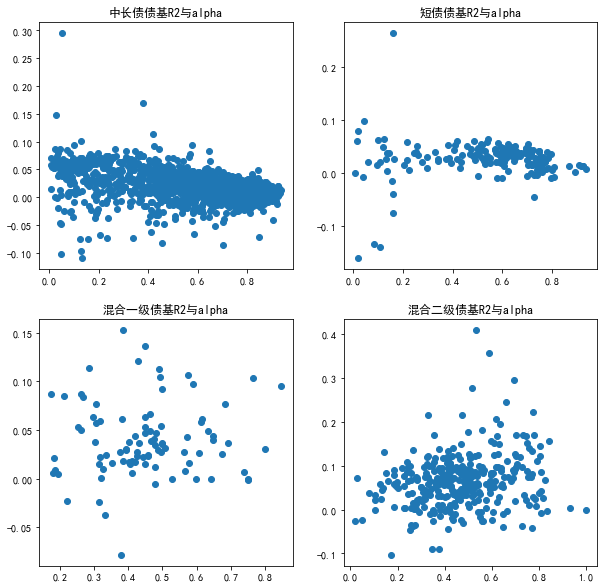


中长债债基解久期与利率曲线结构

短债债基久期与利率曲线结构

混合一级债基久期与利率曲线结构

混合二级债基久期与利率曲线结构


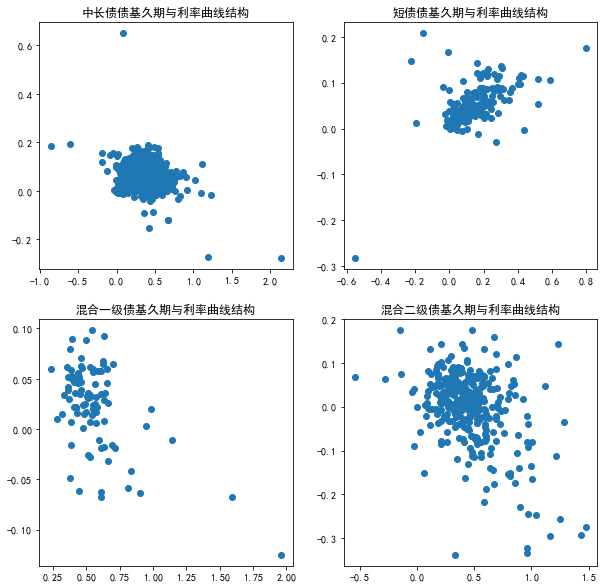

int_date    2.018091e+07
R2          6.342852e-01
久期          3.108507e-01
利率曲线结构      7.120952e-02
信用利差        1.307451e-01
违约          7.260628e-03
可转债         4.301894e-04
alpha       1.927044e-02
dtype: float64
int_date    2.019062e+07
R2          6.041871e-01
久期          1.189360e-01
利率曲线结构      4.355898e-02
信用利差        1.215507e-01
违约          4.092384e-03
可转债         9.473423e-04
alpha       3.003606e-02
dtype: float64
int_date    2.011071e+07
R2          4.483575e-01
久期          5.251627e-01
利率曲线结构      3.154629e-02
信用利差        4.829016e-01
违约          1.979259e-01
可转债         1.147070e-01
alpha       3.294583e-02
dtype: float64
int_date    2.016082e+07
R2          4.594805e-01
久期          4.323953e-01
利率曲线结构      1.282189e-02
信用利差        2.976350e-01
违约         -5.166722e-02
可转债         2.331477e-01
alpha       6.393947e-02
dtype: float64


<ipython-input-22-409c15acce76>:71: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_long.median(axis=0,skipna=True))
<ipython-input-22-409c15acce76>:72: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_short.median(axis=0,skipna=True))
<ipython-input-22-409c15acce76>:73: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_first.median(axis=0,skipna=True))
<ipython-input-22-409c15acce76>:74: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(result_second.median(axis=0,skipna=True))


In [22]:
# 结果分析
# 图1 解释度与超额收益
plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

result_long=pd.read_excel('中长期债基解释度.xlsx')
plt.subplot(221)
plt.scatter(result_long['R2'],result_long['alpha'])
plt.title('中长债债基R2与alpha')
print('\n中长债债基解R2与alpha')


result_short=pd.read_excel('短期债基解释度.xlsx')
plt.subplot(222)
plt.scatter(result_short['R2'],result_short['alpha'])
plt.title('短债债基R2与alpha')
print('\n短债债基R2与alpha')
print(result_short)

result_first=pd.read_excel('混合一级债基解释度.xlsx')
plt.subplot(223)
plt.scatter(result_first['R2'],result_first['alpha'])
plt.title('混合一级债基R2与alpha')
print('\n混合一级债基R2与alpha')


result_second=pd.read_excel(r'混合二级债基解释度.xlsx')
plt.subplot(224)
plt.scatter(result_second['R2'],result_second['alpha'])
plt.title('混合二级债基R2与alpha')
print('\n混合二级债基R2与alpha')

plt.show()

# 久期因子与斜率因子
plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

result_long=pd.read_excel('中长期债基解释度.xlsx')
plt.subplot(221)
plt.scatter(result_long['久期'],result_long['利率曲线结构'])
plt.title('中长债债基久期与利率曲线结构')
print('\n中长债债基解久期与利率曲线结构')
# print(result_long.median())

result_short=pd.read_excel('短期债基解释度.xlsx')
plt.subplot(222)
plt.scatter(result_short['久期'],result_short['利率曲线结构'])
plt.title('短债债基久期与利率曲线结构')
print('\n短债债基久期与利率曲线结构')
# print(result_short.median())

result_first=pd.read_excel('混合一级债基解释度.xlsx')
plt.subplot(223)
plt.scatter(result_first['久期'],result_first['利率曲线结构'])
plt.title('混合一级债基久期与利率曲线结构')
print('\n混合一级债基久期与利率曲线结构')
# print(result_first.median())

result_second=pd.read_excel(r'混合二级债基解释度.xlsx')
plt.subplot(224)
plt.scatter(result_second['久期'],result_second['利率曲线结构'])
plt.title('混合二级债基久期与利率曲线结构')
print('\n混合二级债基久期与利率曲线结构')
# print(result_second.median())
plt.show()

# 中位数
print(result_long.median(axis=0,skipna=True))
print(result_short.median(axis=0,skipna=True))
print(result_first.median(axis=0,skipna=True))
print(result_second.median(axis=0,skipna=True))

# 回测

In [72]:
time1=[datetime.strftime(x,'%F') for x in pd.date_range('2014-01-01','2021-9-30',freq='Q')]
time1.append(last)
time=pd.Series(time1).str.replace(r'-','').astype('int')
time0=(np.array(time)-10000).tolist()
time3=pd.Series(time1).shift(-1).dropna().tolist()
tim3=time3.append('2021-12-31')
print(time3)
# time3=['2015-12-31','2016-12-31','2017-12-31','2018-12-31','2019-12-31','2020-12-31','2021-12-11','2021-12-31']
print(time1)

['2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-11', '2021-12-31']
['2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-11']


In [73]:
def fund_huice(fund,fund_rate):
    fund['int_date']=fund['incdate'].apply(lambda x: x.strftime('%Y%m%d')).astype('int')
    fund=fund[(fund['int_date']<20201231)]
    fund_year=fund.copy()
    R2=np.zeros(len(fund_year))
    COEF=np.full([len(fund_year),5],np.nan)
    ALPHA=np.zeros(len(fund_year))
    fund_slice=pd.Series([],dtype=pd.StringDtype())#截取基金名单
    fund_rating=fund_rate.iloc[:,0:len(fund_slice)]
    fund_invest=pd.Series([],dtype=pd.StringDtype())
    annuallist=pd.Series([],dtype=pd.StringDtype())
    shouyi=pd.Series([],dtype=pd.StringDtype())
    yinzi_ave=pd.DataFrame([],dtype=pd.StringDtype())
    baolu=pd.DataFrame([],dtype=pd.StringDtype())
    #选取一年前成立的基金
    """想法就是说比如：样本为2013.12.31前（一年前成立）成立的基金，需要回归2014.12.31-2015.12.31年间的债基收益率，
    然后选出当年的alpha前五，在2015.12.31-2016.12.31投入。
    那么应该是三个时间序列。成立时间序列，回归时间序列，投入时间序列
    先写回归时间序列time1：time1=[datetime.strftime(x,'%F') for x in pd.date_range('2014-01-01',last,freq='Q')]QWMY
    然后成立时间序列time0：time=pd.Series(time1).str.replace(r'-','').astype('int')；
    time0=(np.array(time)-601).tolist()
    最后投入时间序列：time3=time1后移一期。
    以年为例子，投入时间序列是2015.12.31-2016.12.31,2016.12.31-2017.12.31,2017.12.31-2018.12.31,2018.12.31-2019.12.31,2019.12.31-2020.12.31,2020.12.31-2021.12.11
                那么回归序列是2014.12.31-2015.12.31,2015.12.31-2016.12.31,2016.12.31-2017.12.31,2017.12.31-2018.12.31,2018.12.31-2019.12.31,2019.12.31-2020.12.31
                呢么成立序列是2013.12.31-2014.12.31,2014.12.31-2015.12.31,2015.12.31-2016.12.31,2016.12.31-2017.12.31,2017.12.31-2018.12.31,2018.12.12-2019.12.31
                time3=[2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-11,2021-12-31]
                time1=[2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31]
                time0=[2013-12-31,2014-12-31,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31] 
                但是次数是只到len(time1)-1"""
    for h in trange(len(time1)-1):
        fund_slice=fund_year[(fund_year['int_date']<time0[h])] #截取基金名单——样本为当期一年前成立的基金
        fund_rating=fund_rate.iloc[:,0:len(fund_slice)] #获取对应基金名单的基金数据
        ALPHA=np.zeros(len(fund_slice)) #alpha初始化
        for i in range(len(fund_slice)):
            y=fund_rating.loc[time1[h]:time1[h+1],fund_slice['fcode'].iloc[i]]  #截取需要回归的收益率序列
            z=pd.concat([y,factor],axis=1).dropna()
            xx=np.array(z.loc[:,'level':'convert'])
            yy=np.array(z.iloc[:,0])
            model = LinearRegression()
            model.fit(xx, yy)
            r2=model.score(xx,yy)
            coef=model.coef_
            alpha=model.intercept_
            R2[i]=r2
            COEF[i]=coef
            ALPHA[i]=alpha
            
        fund_slice=fund_slice.copy()
        fund_slice['alpha']=ALPHA
        fund_rank=fund_slice.sort_values(by='alpha',ascending=False) #alpha排名
        #投资基金名单
        fund_toinvest=fund_rank.reset_index(drop=True).loc[0:4,:] #前五
        fund_list=fund_toinvest['fcode'].tolist()
        annuallist[h]=fund_list #历年投入名单
        #因子暴露均值
        COEF_mat=pd.DataFrame(COEF).dropna()
        COEF_ave=COEF_mat.median()
        yinzi_ave=yinzi_ave.append([COEF_ave.values])
        #各基金的因子暴露
        timeline=pd.Series(np.full(len(fund_year),time1[h]))
        yinzi0=fund_year.copy()
        COEF_df=pd.DataFrame(COEF)
        COEF_df.columns=['level','slope','credit','default','convert']
#         print(COEF_df)
        yinzi=pd.concat([yinzi0,COEF_df,timeline],axis=1)
        baolu=baolu.append(yinzi)
        
        for j in range(len(fund_list)):
            fund_inv=fund_rating.loc[time3[h]:time3[h+1],fund_list[j]] #投入业绩回报，也就是投入序列
            fund_invest=pd.concat([fund_invest,fund_inv],axis=1)
        shouyi=pd.Series(fund_invest.mean(axis=1))
    yinzi_ave.index=pd.to_datetime(time1[:len(time1)-1]) #历年因子暴露
    yinzi_ave.columns=['level','slope','credit','default','convert']
    annuallist.index=pd.to_datetime(time3[:len(time3)-1]) #历年投入名单
    baolu #各基金历年因子暴露
    return shouyi,annuallist,yinzi_ave,baolu

In [74]:
huice_short,annuallist_short,yinzi_short,baolu_short=fund_huice(fund_short,fund_short_rate)
huice_short.to_excel('短期债基回测.xlsx',index=True)
yinzi_short.to_excel('短期债基因子暴露.xlsx',index=True)
baolu_short.to_excel('短期债基各自暴露.xlsx',index=True)
huice_long,annuallist_long,yinzi_long,baolu_long=fund_huice(fund_long,fund_long_rate)
huice_long.to_excel('中长期债基回测.xlsx',index=True)
yinzi_long.to_excel('中长期债基因子暴露.xlsx',index=True)
baolu_long.to_excel('中长期债基各自暴露.xlsx',index=True)
huice_first,annuallist_first,yinzi_first,baolu_first=fund_huice(fund_first,fund_first_rate)
huice_first.to_excel('混合一级债基回测.xlsx',index=True)
yinzi_first.to_excel('混合一级债基因子暴露.xlsx',index=True)
huice_second,annuallist_second,yinzi_second,baolu_second=fund_huice(fund_second,fund_second_rate)
huice_second.to_excel('混合二级债基回测.xlsx',index=True)
yinzi_second.to_excel('混合二级债基因子暴露.xlsx',index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


Text(0.5, 1.0, '混合二级债基因子暴露')

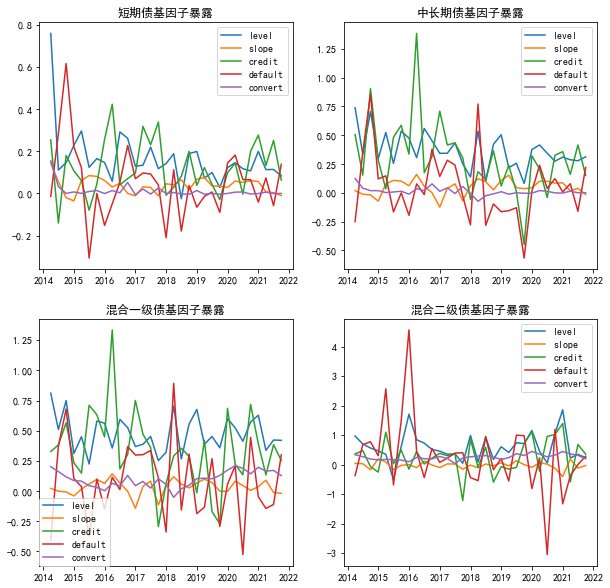

In [75]:

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(yinzi_short)
plt.legend(yinzi_short.columns)
plt.title('短期债基因子暴露')

plt.subplot(222)
plt.plot(yinzi_long)
plt.legend(yinzi_long.columns)
plt.title('中长期债基因子暴露')

plt.subplot(223)
plt.plot(yinzi_first)
plt.legend(yinzi_first.columns,bbox_to_anchor=(0,0), loc=3, borderaxespad=0)
plt.title('混合一级债基因子暴露')

plt.subplot(224)
plt.plot(yinzi_second)
plt.legend(yinzi_second.columns)
plt.title('混合二级债基因子暴露')

In [20]:
# 导入对应债基指数
basementlist0=["CBA02501.CS","CBA02511.CS","CBA02521.CS","CBA02531.CS","CBA02541.CS","CBA02551.CS","CBA02561.CS"]
basementimport=w.wsd(basementlist0,"pct_chg", start, last, "Period=W")
basementlist1=['zong','<1','1-3','3-5','5-7','7-10','>10']
dates=pd.to_datetime(basementimport.Times)
basement= pd.DataFrame(basementimport.Data).T
basement.index = dates.strftime("%Y-%m-%d")
basement.columns = basementlist1


In [77]:
# 回测指标
from empyrical import (
    cum_returns,
    annual_return,
    annual_volatility,
    downside_risk,
    max_drawdown,
    sharpe_ratio,
    sortino_ratio,
    calmar_ratio,
)
def huicezhibiao(returns):
    returns=returns/100
    print('累计收益：',cum_returns(returns)[-1])
    print('最大回撤：',max_drawdown(returns))
    print('年化收益：',annual_return(returns,period='weekly'))
    print('年化波动率：',annual_volatility(returns, period='weekly'))
    print('卡玛比率：',calmar_ratio(returns))
    print('夏普比率：',sharpe_ratio(returns=returns))
    return
print('短期债基回测')
huicezhibiao(huice_short)
print('\n中长期债基回测')
huicezhibiao(huice_long)
print('\n混合一级债基回测')
huicezhibiao(huice_first)
print('\n混合二级债基回测')
huicezhibiao(huice_second)

短期债基回测
累计收益： 0.45095474033520233
最大回撤： -0.015263295064382567
年化收益： 0.05183540055515645
年化波动率： 0.015396571091596777
卡玛比率： 18.181145873171662
夏普比率： 7.246118013788696

中长期债基回测
累计收益： 0.4519616782597651
最大回撤： -0.025181855969017012
年化收益： 0.05193447713031407
年化波动率： 0.022958125836751837
卡玛比率： 11.043167483420461
夏普比率： 4.882462332471689

混合一级债基回测
累计收益： 0.8157246317511488
最大回撤： -0.08212795571792521
年化收益： 0.08435447817617137
年化波动率： 0.05964305513885563
卡玛比率： 5.85216282465975
夏普比率： 3.05696882631015

混合二级债基回测
累计收益： 1.324746308640825
最大回撤： -0.2674859743929665
年化收益： 0.12135441370422195
年化波动率： 0.1326162338993302
卡玛比率： 2.7741808636601073
夏普比率： 2.0491792654652343
